In [1]:
from datasets import load_dataset
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import math

from nltk.corpus import stopwords


/Users/simonwallace/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("refugee-law-lab/canadian-legal-data", "FC", split="train")

# convert to dataframe
df = pd.DataFrame(dataset)

In [3]:
df = df[df['language'] == 'en'].reset_index(drop=True)
df['unofficial_text'] = df['unofficial_text'].str.lower()

In [4]:
def split_decision(text):
    if '[1]' not in text:
        begin = 'FAIL'
        middle = ''
        end = ''
        return begin, middle, end
    begin = text.split('[1]', 1)[0]
    middle = text.split('[1]', 1)[1]
    
    paras = [para for para in middle.split('\n') if len(para) > 1 and para[0] == '[' and para[1].isdigit()]
    
    if len(paras) == 0:
        begin = 'FAIL'
        middle = ''
        end = ''
        return begin, middle, end
    
    final_para = paras[-1]
    parts = middle.split(final_para, 1)
    
    middle = parts[0] + final_para
    end = parts[1]

    return begin, middle, end

In [5]:
df['begin'], df['middle'], df['end'] = zip(*df['unofficial_text'].map(split_decision))

In [6]:
(df['begin'] == 'FAIL').sum()

np.int64(477)

In [7]:
df = df[df['begin'] != 'FAIL'].reset_index(drop=True)
df.shape

(32388, 14)

In [8]:
# remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# remove all non whitespace and non alpha characters
def remove_non_alpha(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

df['middle'] = df['middle'].apply(remove_punctuation)

df['middle'] = df['middle'].apply(remove_non_alpha)

In [9]:
def word_count(text):
    return len(text.split())

df['word_count'] = df['middle'].apply(word_count)

In [10]:
df['word_count'].describe()

count     32388.000000
mean       3307.259479
std        4243.091847
min          22.000000
25%        1289.000000
50%        2305.500000
75%        3836.000000
max      147589.000000
Name: word_count, dtype: float64

In [11]:
# get chunks of text
# window size: 100
# identify percentage of the way through text

marks = [10,20,30,40,50,60,70,80,90]

def get_chunks(text, window_size=100, marks=marks):
    chunks = []
    text = text.split()
    for mark in marks:
        start = math.floor((mark/100)*len(text))
        end = start + window_size
        if end > len(text):
            end = len(text)
        chunk = ' '.join(text[start:end])
        chunks.append(chunk)
    return chunks

df['chunks'] = df['middle'].apply(get_chunks)

In [18]:
for i in range(len(marks)):
    df['chunk_' + str(marks[i])] = df['chunks'].apply(lambda x: x[i])

In [ ]:
analysis = pd.DataFrame()

def get_word_counter(text):
    return Counter(text.split())


for i in range(len(marks)):
    analysis['word_counter_' + str(marks[i])] = df['chunk_' + str(marks[i])].apply(get_word_counter)

In [ ]:
def count_word(word, word_counter):
    value = word_counter[word]
    return word_counter[word]

In [134]:
analysis.loc[0, 'word_counter_10']['refugee']

0

In [138]:
for mark in marks:
    proportion = analysis['word_counter_' + str(mark)].apply(lambda counter: count_word('the', counter)).mean()
    print(f'A {mark}%: {proportion}')

A 10%: 9.030041990860813
A 20%: 9.213103618624181
A 30%: 9.140391503025812
A 40%: 9.103093738421638
A 50%: 9.16762381128813
A 60%: 9.233049277510188
A 70%: 9.264635050018525
A 80%: 9.215666296159071
A 90%: 8.844016302334198


In [62]:
words = pd.DataFrame()

for idx,word in enumerate(stopwords.words('english')):
    words.loc[idx, 'word'] = word
    for mark in marks:
        proportion = analysis['word_counter_' + str(mark)].apply(lambda counter: count_word(word, counter)).mean()
        words.loc[idx, f'{mark}%'] = proportion

words.set_index('word', inplace=True)

In [68]:
words.sort_values('50%', ascending=False, inplace=True)
words

,10%,20%,30%,40%,50%,60%,70%,80%,90%
word,,,,,,,,,
the,9.030042,9.213104,9.140392,9.103094,9.167624,9.233049,9.264635,9.215666,8.844016
of,3.572743,3.727368,3.827837,3.857818,3.863777,3.771767,3.723478,3.655984,3.507163
to,3.075090,3.043535,3.008182,3.016271,3.035630,3.143448,3.193899,3.221317,3.055545
that,2.076170,2.385390,2.443065,2.482710,2.504292,2.551655,2.577837,2.544121,2.349728
in,2.513153,2.346054,2.292454,2.299432,2.348679,2.386378,2.427257,2.429048,2.268155
...,...,...,...,...,...,...,...,...,...
doesn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doesn't,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hadn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: >

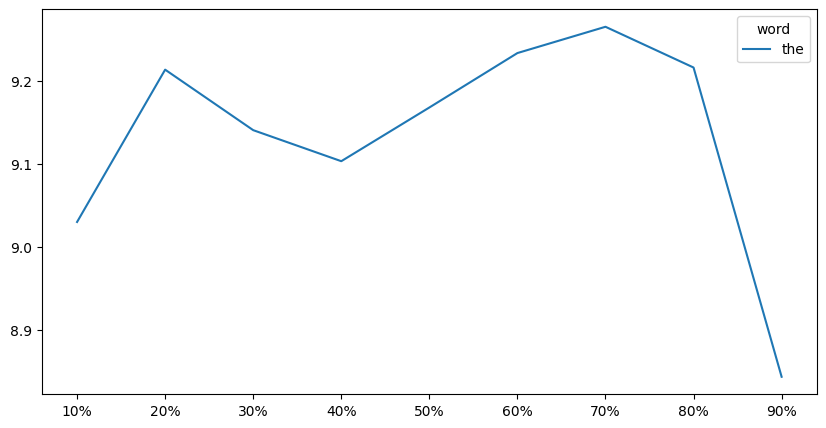

In [83]:
words[:1].T.plot(kind='line', figsize=(10,5))

In [85]:
words.head(30)

,10%,20%,30%,40%,50%,60%,70%,80%,90%
word,,,,,,,,,
the,9.030042,9.213104,9.140392,9.103094,9.167624,9.233049,9.264635,9.215666,8.844016
of,3.572743,3.727368,3.827837,3.857818,3.863777,3.771767,3.723478,3.655984,3.507163
to,3.075090,3.043535,3.008182,3.016271,3.035630,3.143448,3.193899,3.221317,3.055545
that,2.076170,2.385390,2.443065,2.482710,2.504292,2.551655,2.577837,2.544121,2.349728
in,2.513153,2.346054,2.292454,2.299432,2.348679,2.386378,2.427257,2.429048,2.268155
and,2.556317,2.346733,2.260837,2.190132,2.158979,2.126652,2.069625,2.050790,1.986878
a,2.137520,1.991818,1.954582,1.928832,1.865135,1.811288,1.782481,1.736569,1.625633
is,0.751451,0.955601,1.156076,1.265345,1.321631,1.348524,1.358404,1.359145,1.394035
not,0.754570,0.913270,0.968322,1.028375,1.083735,1.137273,1.198716,1.233945,1.208225


<Axes: ylabel='word'>

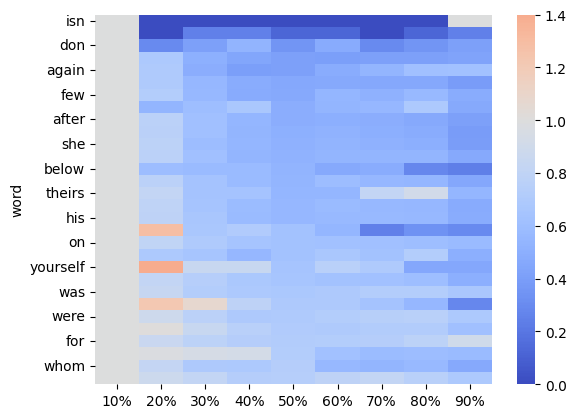

In [93]:
heatmap = words.div(words['10%'], axis=0)
heatmap.sort_values('50%', ascending=True, inplace=True)
sns.heatmap(heatmap.head(30), cmap='coolwarm', center=1)

In [99]:
words = words[words > 0].dropna()

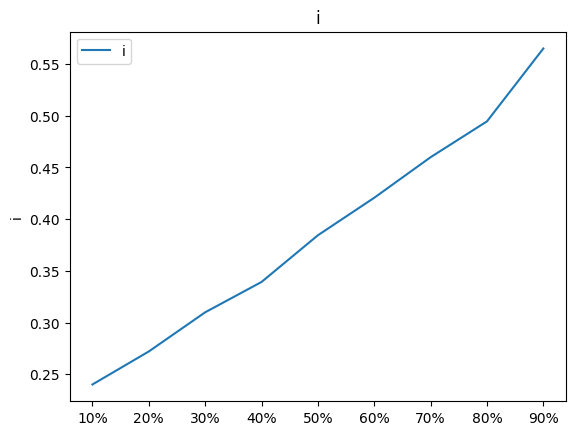

<Figure size 640x480 with 0 Axes>

In [132]:
to_search = ['i']

for idx, row in words.loc[to_search].iterrows():
    sns.lineplot(data=row, label=idx)
    plt.title(row.name)
    plt.show()
    plt.clf()

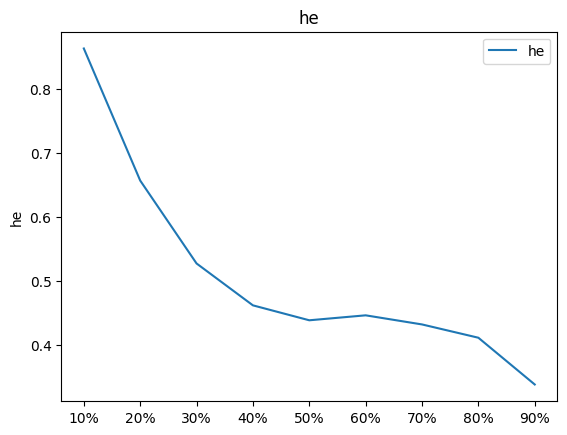

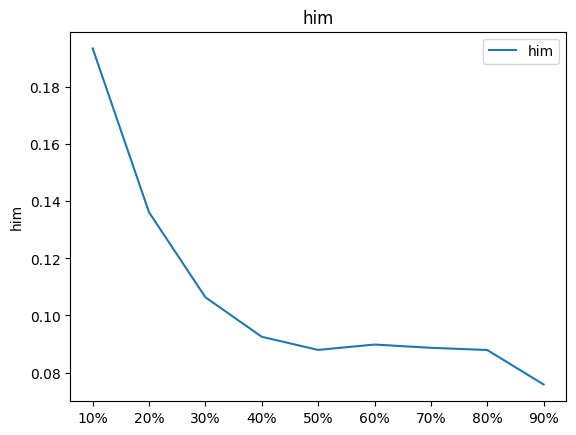

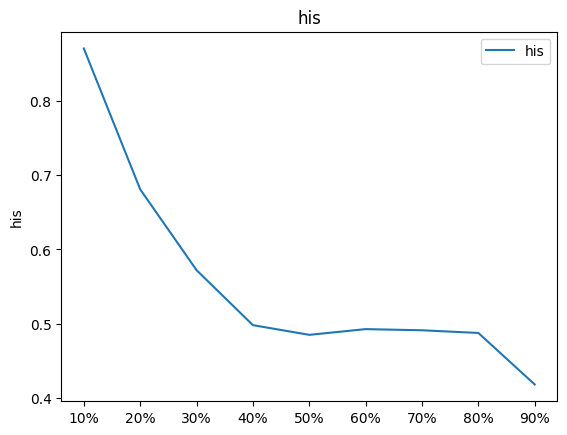

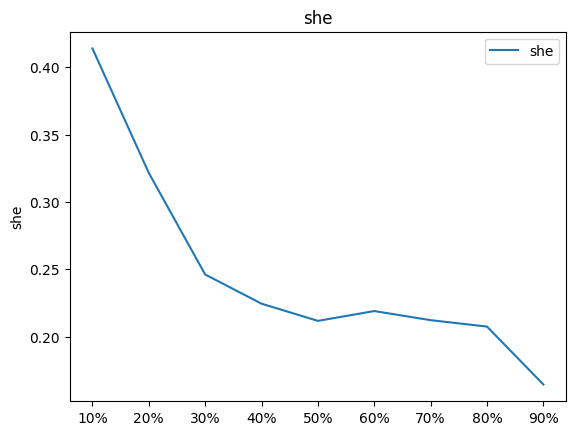

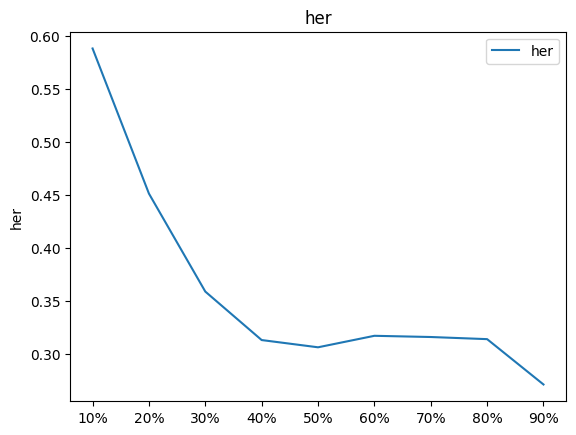

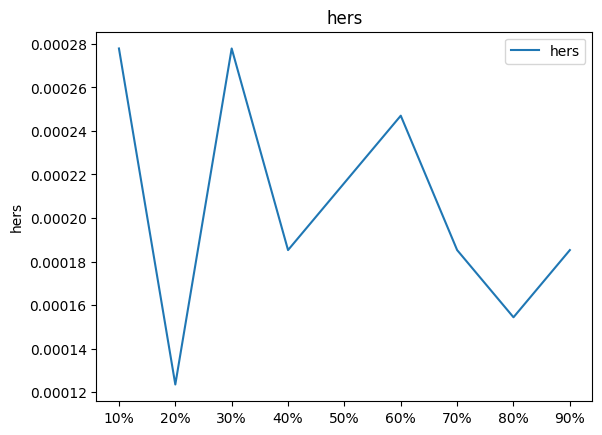

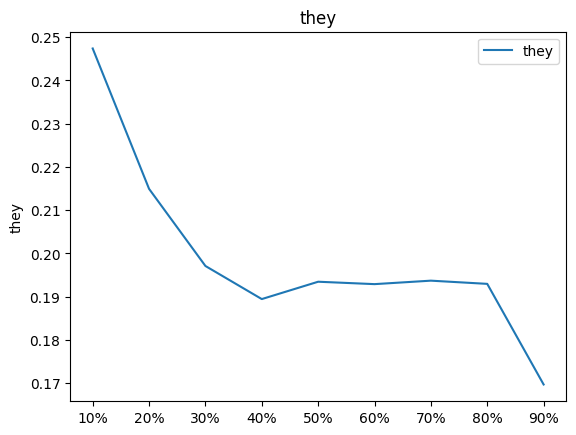

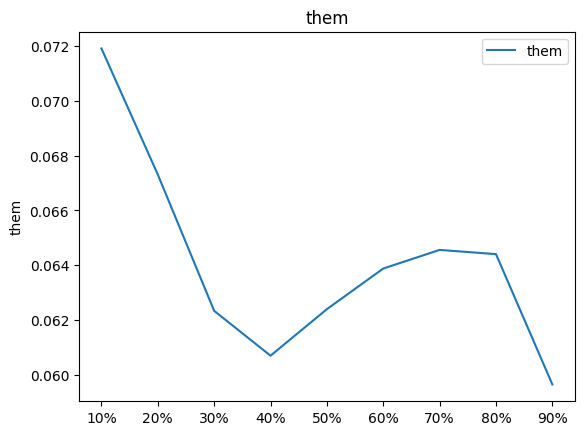

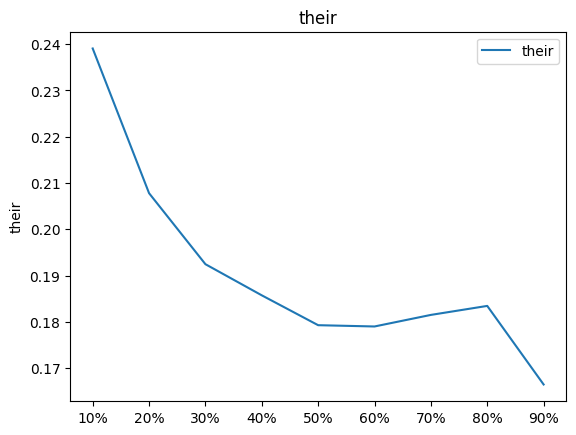

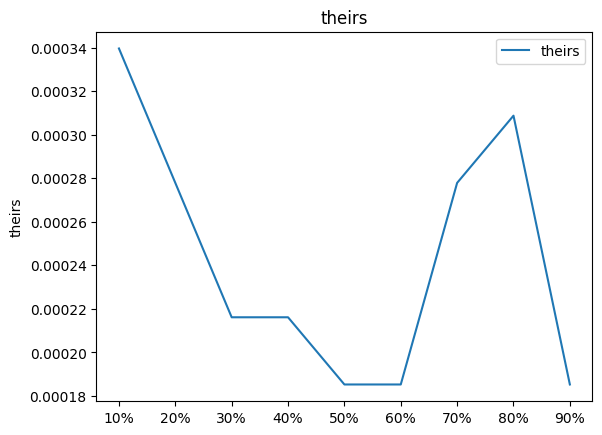

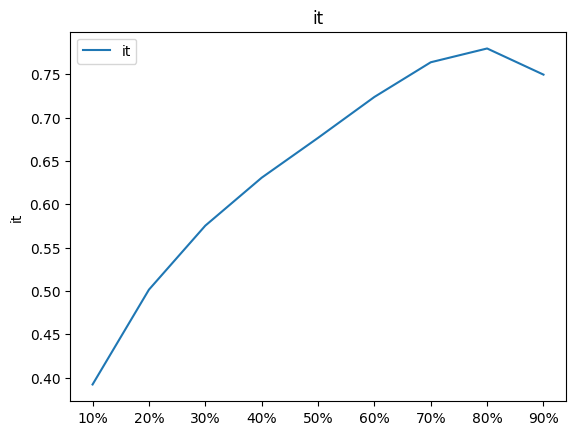

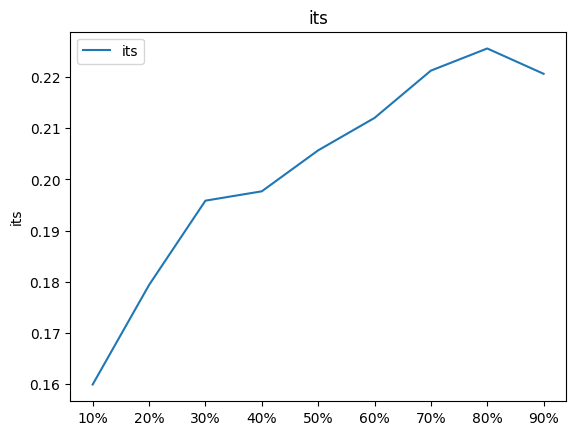

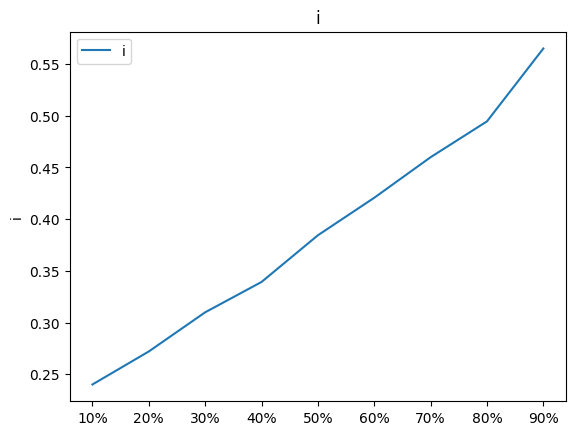

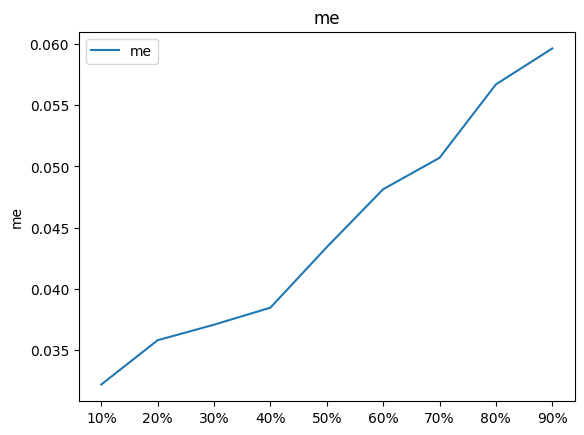

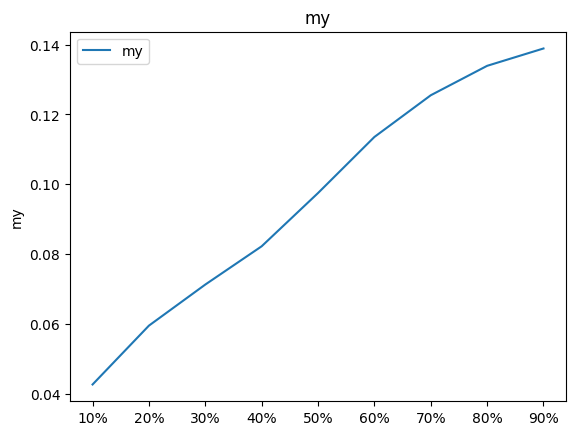

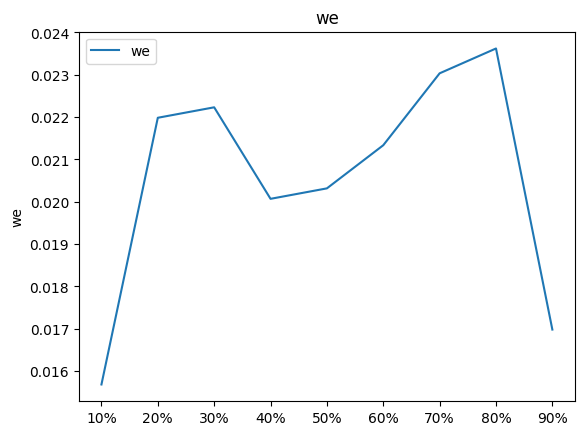

<Figure size 640x480 with 0 Axes>

In [109]:
for idx, row in words.loc[['he','him','his','she','her','hers','they','them','their','theirs','it','its','i','me','my','we']].iterrows():
    sns.lineplot(data=row, label=idx)
    plt.title(row.name)
    plt.show()
    plt.clf()

<Axes: >

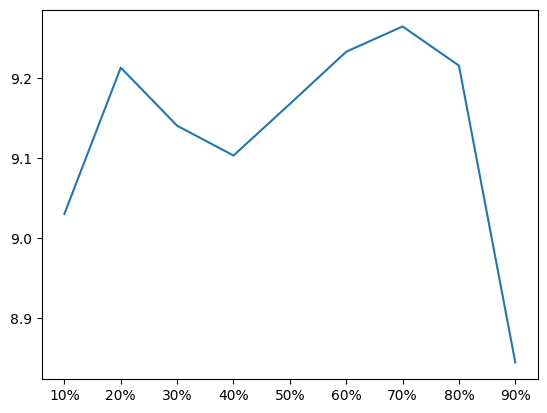

In [111]:
words.loc['the'].plot()

<Axes: >

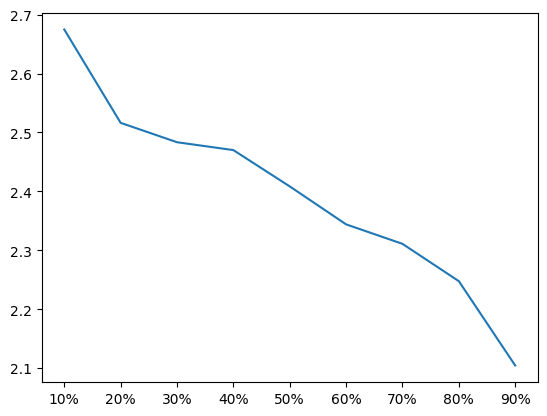

In [117]:
(words.loc['a'] + words.loc['an']).plot()

In [125]:
df['chunk_10'].apply(lambda x: len(x.split())).describe()

count    32388.000000
mean        99.942046
std          1.553685
min         20.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: chunk_10, dtype: float64

In [128]:
df[df['chunk_10'].apply(lambda x: len(x.split())) < 100]

,citation,citation2,dataset,year,name,language,document_date,source_url,scraped_timestamp,unofficial_text,...,chunk_85,chunk_95,chunk_10,chunk_20,chunk_30,chunk_40,chunk_60,chunk_70,chunk_80,chunk_90
93,2001 FCT 1084,,FC,2001,Denis v. Canada (Minster of Citizenship and Im...,en,2001-10-02,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-18,denis v. canada (minster of citizenship and im...,...,my opinion this conclusion was fully justified...,for judicial review is dismissed,that the visa officer erred in awarding him po...,the occupational factor his application for ju...,be dismissed the national occupational classif...,person who wishes to immigrate to canada in th...,degree in translation or in a related discipli...,visa officer concluded that the applicants dip...,the noc requirements in my opinion this conclu...,fully justified consequently the application f...
94,2001 FCT 1085,,FC,2001,Wishart v. Canada (Minister of Citizenship and...,en,2001-10-02,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-18,wishart v. canada (minister of citizenship and...,...,immigration officer committed any reviewable e...,for judicial review is dismissed,decision of p phinn an immigration officer whe...,immigration officer decided not to exempt the ...,from the requirements of subsection of the imm...,rsc c i the act neither the applicant nor his ...,me i have therefore reviewed all the evidence ...,and read the parties written representations a...,not satisfied that the immigration officer com...,reviewable error the application for judicial ...
101,2001 FCT 1091,,FC,2001,Cirahan v. Canada (Minister Of Citizenship And...,en,2001-10-03,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-18,cirahan v. canada (minister of citizenship and...,...,his application for a stay of execution of the...,order made against him is dismissed,the existence of a serious question i need not...,this issue after reviewing the evidence and co...,made by both sides i have not been persuaded t...,irreparable harm will result if i do not grant...,the applicant has not met the relevant test as...,by the federal court of appeal in toth v minis...,of employment and immigration nr his applicati...,of execution of the deportation order made aga...
139,2001 FCT 1125,,FC,2001,Pinte v. Canada (Minister of Citizenship and I...,en,2001-10-16,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-18,pinte v. canada (minister of citizenship and i...,...,his application is hereby dismissed,hereby dismissed,conduct is clear and leads to only one conclus...,and leads to only one conclusion ie that he is...,only one conclusion ie that he is not serious ...,ie that he is not serious about his judicial r...,serious about his judicial review application ...,judicial review application consequently his a...,consequently his application is hereby dismissed,is hereby dismissed
166,2001 FCT 115,,FC,2001,Magham v. Canada (Minister of Citizenship and ...,en,2001-02-26,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-18,magham v. canada (minister of citizenship and ...,...,the circumstances there is no necessity for a ...,redetermination no certified question arises,the court set aside the decision of the refuge...,refugee division of the immigration and refuge...,denying the applicant his claim to refugee sta...,my view the setting aside of that decision mat...,claims officer pcdo as a result this judicial ...,application is allowed and the decision of the...,pcdo is quashed in the circumstances there is ...,no necessity for a redetermination no certifie...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21075,2016 FC 259,,FC,2016,Ty Inc. v. Promotions C.D. Inc.,en,2016-02-29,https://decisions.fct-cf.gc.ca/fc-cf/decisions...,2022-08-24,ty inc. v. promotions c.d. inc.\ncourt (s) dat...,...,consent of the parties filed,parties filed,plaintiffs motion for judgment against the def...,judgment against the defendant read

In [12]:
def shannon_entropy(tokens):
    entropy = 0
    num_tokens = len(tokens)
    frequencies = Counter(tokens)
    
    for token, count in frequencies.items():
        p = count / num_tokens
        entropy += p * math.log2(p)
    
    return -entropy

In [19]:
# just chunk columns
columns = [column for column in df.columns if 'chunk_' in column]
entropy = df[columns].copy()

In [21]:
entropy = entropy[entropy['chunk_90'].apply(lambda x: len(x.split())) == 100]

In [22]:
entropy = entropy.map(lambda x: shannon_entropy(x.split()))

<Axes: ylabel='Frequency'>

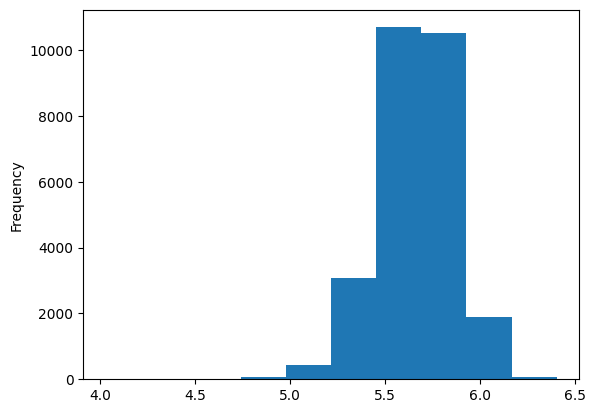

In [31]:
entropy['chunk_10'].plot(kind='hist')

(4.5, 7.0)

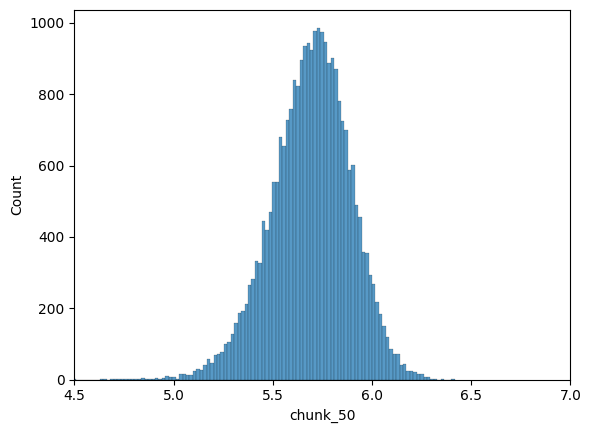

In [36]:
sns.histplot(entropy['chunk_50'])
plt.xlim(4.5,7)

<Axes: >

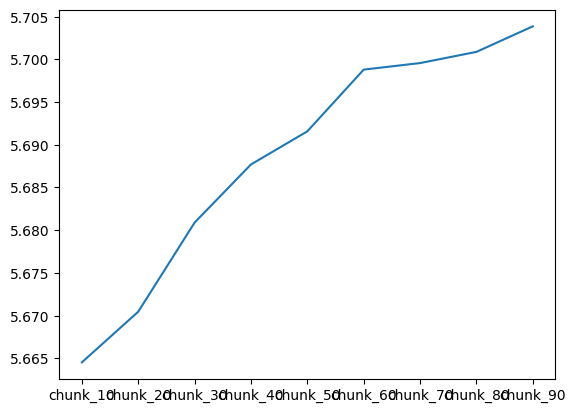

In [25]:
entropy.mean(axis=0).plot()

In [26]:
2**5.665

50.738184743058206

In [27]:
2**5.705

52.16462927376803

In [29]:
(52.164/50.73)-1

0.028267297457126084

In [39]:
chunks = df[columns].copy()

In [40]:
chunks = chunks.map(lambda x: len(set(x)))

<Axes: >

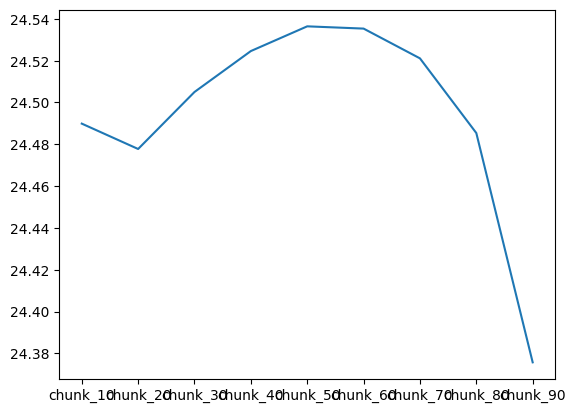

In [46]:
chunks.mean(axis=0).plot()